In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from Sk import Sk as p_kp
from scipy.io import loadmat


In [2]:
# use KAN
import yaml
import sys
sys.path.append('KAN/')
from use_KAN import *
import use_KAN
with open('./KAN/setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
device = torch.device('cpu')
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)
model_KAN.load_state_dict(torch.load('./KAN/saved_model/KAN/model_9_7_sin_full_ft.pth'))
def f_SQ_KAN(model, x, Q=Q):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Produce synthetic data

In [3]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def S_yukawa(QD, phi, kappa, A, Q_low = 2, Q_high = 2.5):
    x = np.array([phi, kappa, A])
    Q_list = np.linspace(0, np.max(QD), 100)
    x[2] = np.log(x[2])
    x = x.reshape(1, -1)
    x = to_torch_device(x)
    q = Q_list
    S_list = f_SQ_KAN(model_KAN, x, Q=q).detach().numpy()[0]
    # Fit a quadratic function to the range Q = 2 to 2.5
    Q_fit = Q_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    S_fit = S_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    X_fit = np.vstack([Q_fit**2, np.ones(Q_fit.shape)]).T
    coefficients = np.linalg.lstsq(X_fit, S_fit, rcond=None)[0]

    # Fill Q < Q_low using the quadratic fit
    S_list[Q_list < Q_low] = coefficients[0] * Q_list[Q_list < Q_low]**2 + coefficients[1]
    f_S = interp1d(Q_list, S_list, kind='cubic')
    
    S = f_S(QD)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

def P_ss(QD, softness=0.2):
    P = np.exp(-QD**2/2*softness**2)*(3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1  
    return P

def P_fuzzy(QR, R2, sigma1, sigma2, rc):
    j1 = lambda QR: (np.sin(QR)-QR*np.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*np.exp(-(Qsigma/2)**2)/QR
    
    QR1 = QR
    QR2 = QR*R2
    Qsigma2 = QR*sigma2
    Qsigma1 = QR*sigma1
    
    P = (rc*F1(QR1,Qsigma1)+(1-rc)*F1(QR2,Qsigma2))**2
    
    return P

def P_star(QR, Rg):
    P = ((1-np.exp(-QR**2*Rg**2))/(QR**2*Rg**2))**2
    
    return P

def p_debye(Q,Rg):
    QRg = Q*Rg
    u = QRg**2
    p = 2*(np.exp(-u)+u-1)/(u**2)
    p[QRg==0] = 1
    return p

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

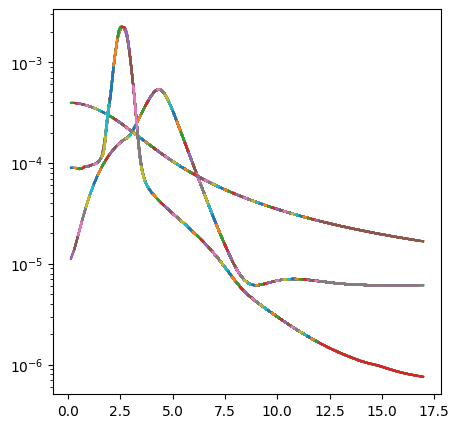

In [4]:
q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 5e-4

scale = 1
P = P_ss(q_rad*scale, softness=0.2)
# P = P_fuzzy(q_rad*scale, 1.2, 0.02, 0.02, 1)
# P = P_star(q_rad*scale, np.sqrt(0.6)/2)
# S = S_hs(q_rad*scale, 0.25)
S = S_yukawa(q_rad*scale, 0.15, 0.2, 10, Q_low=2.75, Q_high=3)
p_colloid = P*S + I_inc*8
p_colloid[np.isfinite(p_colloid)==0] = 0
p_colloid = p_colloid/np.sum(p_colloid) 

vfunc = np.vectorize(lambda q: p_kp(np.array([q/2,q]), 10, 0.5)[0]) 
p_polymer = vfunc(q_rad) + I_inc
p_polymer[np.isfinite(p_polymer)==0] = 0
p_polymer = p_polymer/np.sum(p_polymer) 

data_sponge = loadmat('data/S_q_0.mat')
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/129
dq = 2*np.pi/box_size
q_sponge = np.arange(n_grid_scale/2)*dq/23
Sq_sponge = data_sponge['S_q_kxy'][1]/1e-6
Sq_sponge[0] = Sq_sponge[1]
f_interp = interp1d(q_sponge, Sq_sponge, kind='cubic')
p_sponge = f_interp(q_rad) + I_inc
p_sponge[np.isfinite(p_sponge)==0] = 0
p_sponge = p_sponge/np.sum(p_sponge) 

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(q_rad, p_colloid, label='Colloid')
ax.plot(q_rad, p_polymer, label='Polymer')
ax.plot(q_rad, p_sponge, label='Sponge')

ax.set_yscale('log')
# ax.set_xscale('log')

In [5]:
n_sample = 10000

#### generate random samples
n_pixel = n_sample/p_colloid.shape[0]  # number of samples per pixel

# Flatten the arrays
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy, seed =19810):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

## random sampling
I_q_grid_colloid = f_I_q(n_sample, p_colloid) ## count per pixel
I_q_colloid, sum_q_colloid, n_pixels_q_colloid, I_pixels_q_colloid = f_I_q_rad(I_q_grid_colloid, q)
I_q_th_colloid, _, _, _ = f_I_q_rad(p_colloid, q)
I_q_th_colloid = I_q_th_colloid*n_sample

I_q_grid_polymer = f_I_q(n_sample, p_polymer) ## count per pixel
I_q_polymer, sum_q_polymer, n_pixels_q_polymer, I_pixels_q_polymer = f_I_q_rad(I_q_grid_polymer, q)
I_q_th_polymer, _, _, _ = f_I_q_rad(p_polymer, q)
I_q_th_polymer = I_q_th_polymer*n_sample

I_q_grid_sponge = f_I_q(n_sample, p_sponge) ## count per pixel
I_q_sponge, sum_q_sponge, n_pixels_q_sponge, I_pixels_q_sponge = f_I_q_rad(I_q_grid_sponge, q)
I_q_th_sponge, _, _, _ = f_I_q_rad(p_sponge, q)
I_q_th_sponge = I_q_th_sponge*n_sample

/tmp/ipykernel_2355165/3284859194.py:40: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_colloid), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2355165/3284859194.py:53: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_polymer), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2355165/3284859194.py:66: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_sponge), cmap='viridis', vmax=3, vmin=-2)


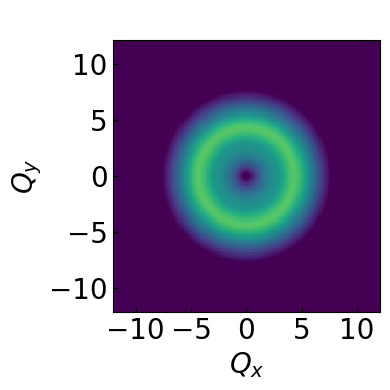

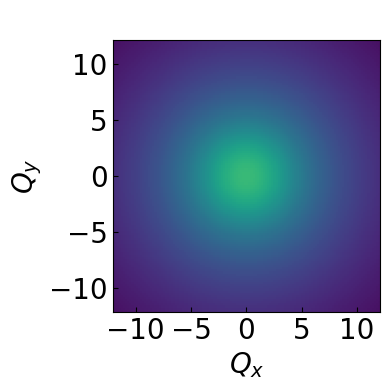

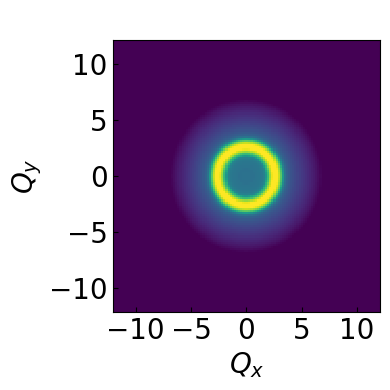

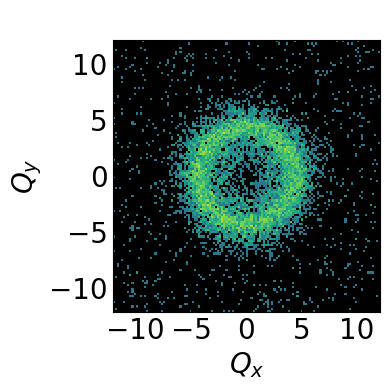

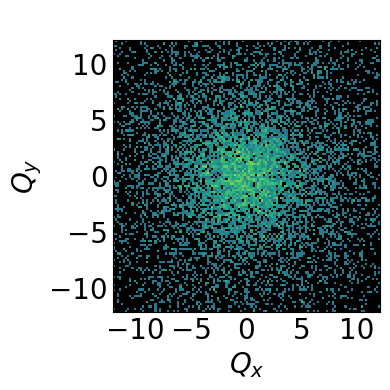

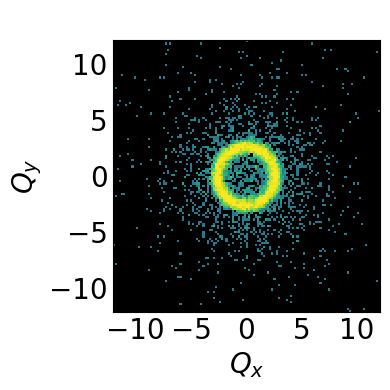

In [6]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_colloid*n_sample), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_polymer*n_sample), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_sponge*n_sample), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_colloid), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_polymer), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_sponge), cmap='viridis', vmax=3, vmin=-2)
ax.set_xlabel(r'$Q_x$', fontsize=20)
ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

## GPR

### Colloid

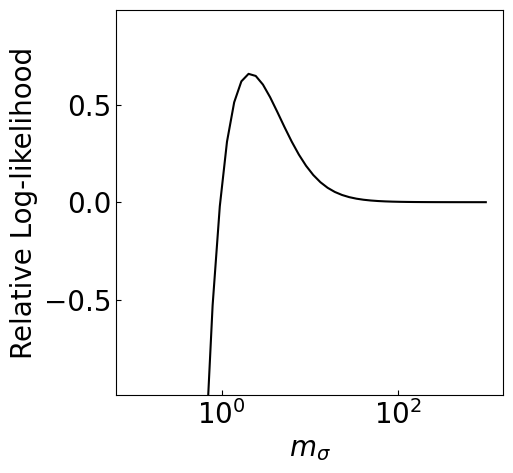

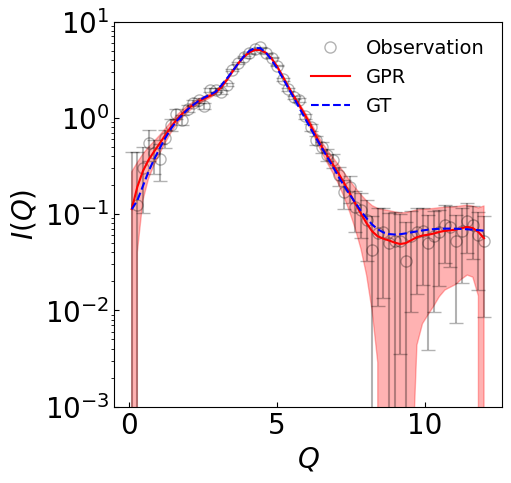

In [41]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.5

I_bg = 1e-1

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_colloid) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_colloid, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    ## define kernel function
    y_data = I_q_concat
    y_bg = I_q_mean_gf
    y_bg_concat = I_q_mean_gf_concat
    y_gt = I_q_th
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg, '-r', label='GPR')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label='GT')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=14, loc='upper right')

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
# ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

# ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)

In [8]:
I_q_list

[array([0.        , 0.125     , 0.3       , 0.55      , 0.42857143,
        0.375     , 0.61363636, 0.84615385, 1.10416667, 0.95      ,
        1.25      , 1.4375    , 1.5326087 , 1.32894737, 1.93      ,
        1.9375    , 1.84      , 2.2037037 , 3.13461538, 3.73571429,
        4.27272727, 4.67424242, 5.16176471, 5.38571429, 4.69767442,
        4.21710526, 3.49390244, 2.50555556, 1.97093023, 1.63043478,
        1.53571429, 1.03431373, 0.79807692, 0.58333333, 0.49528302,
        0.41346154, 0.36065574, 0.25409836, 0.16803279, 0.18965517,
        0.11923077, 0.11153846, 0.08712121, 0.04225352, 0.06338028,
        0.06506849, 0.05      , 0.0528169 , 0.05246914, 0.03289474,
        0.05864198, 0.06493506, 0.06707317, 0.0505618 , 0.05864198,
        0.06460674, 0.07777778, 0.07417582, 0.05263158, 0.06686047,
        0.08421053, 0.0776699 , 0.06060606, 0.0525    ])]

#### effect on data quality

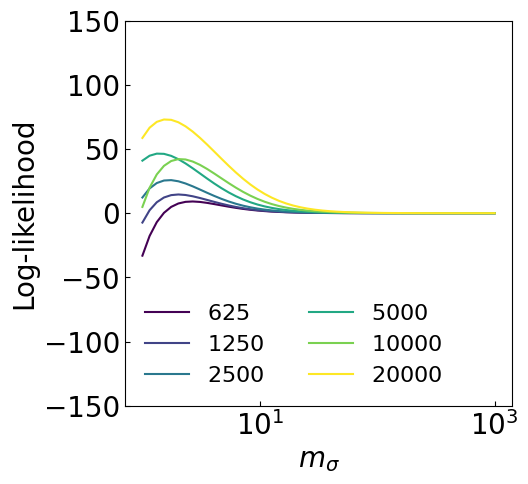

In [42]:
filter_size = 0.5

n_trial = 1
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = [625, 1250, 2500, 5000, 10000, 20000]
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2


    q_list = []
    I_q_gf_list = []
    I_q_sv_list = []
    I_q_list = []
    sum_q_list = []
    n_pixels_q_list = []
    I_err_list = []

    for i in range(n_trial):
        I_q_grid = f_I_q(n_sample, p_colloid) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_colloid, q)
        I_q_th = I_q_th*n_sample
        I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
        I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
        
        I_data_gf = np.zeros_like(q)
        for i in range(len(q)):
            weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
            weight_list = weight_list/np.sum(weight_list)
            I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
        
        I_q_gf_list.append(I_q_gf)
        I_q_sv_list.append(I_q_sv)
        
        I_q_list.append(I_q)
        sum_q_list.append(sum_q)
        n_pixels_q_list.append(n_pixels_q)
        q_list.append(q)
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
        I_err_list.append(I_err_q)
        
    q_concat = np.concatenate(q_list)
    sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
    n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
    I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
    I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
    I_q_gf_concat = np.concatenate(I_q_gf_list)
    I_q_sv_concat = np.concatenate(I_q_sv_list)
    I_q_concat = np.concatenate(I_q_list)

    # average over trials, obtain smoothed I(q) as background
    I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
    I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
    I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
    I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

    I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
    I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
        
    # # Plot the radial averaged density for concatenated values
    # fig = plt.figure(figsize=(6, 6))
    # ax = plt.subplot(1, 1, 1)
    # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
    #     label_I_q = None
    #     label_I_q_gf = None
    #     if i == 0:
    #         label_I_q = 'I_q'
    #         label_I_q_gf = 'I_q_gf'
    #     ax.plot(q, I_q, 'ok', label=label_I_q)
    #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.legend(frameon=False)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q_concat
        y_bg = I_q_mean_gf
        y_bg_concat = I_q_mean_gf_concat
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
        std_s = np.sqrt(var_s)

        # evaluate the log likelihood
        def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
            ## average over the ovservation uncertainty   
            log_likelihood = 0   
            sum_weight = 0  
            for z in np.linspace(0, 0, 1):
                weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
                y_z = y + y_err*z
                log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
                log_likelihood += log_likelihood_z*weight_z
                sum_weight += weight_z
            log_likelihood = log_likelihood/sum_weight
            return log_likelihood

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = log_likelihood_list - log_likelihood_list[-1]

    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-150, 150])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
ax.legend(frameon=False, fontsize=16, ncol=2)

# # # GPR with best sigma
# # f_q = lambda q: np.log(q)
# f_q = lambda q: q
# f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
# K_sigma = np.diag(f_y_err(y_err))
# # K_sigma = sigma**2*np.eye(len(q_x))
# K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
# K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
# k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

# L = np.linalg.cholesky(K_xx)
# alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
# v = np.linalg.solve(L, K_xs)
# mu_s = K_xs.T @ alpha
# cov_s = k_ss - v.T @ v
# var_s = np.diag(cov_s)*y_err**2
# std_s = np.sqrt(var_s)



### Polymer

5.428675439323859


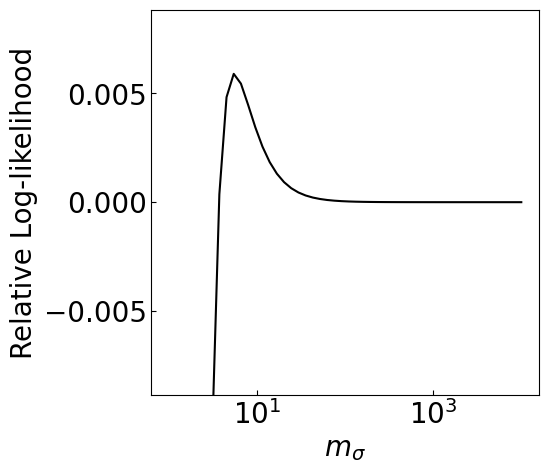

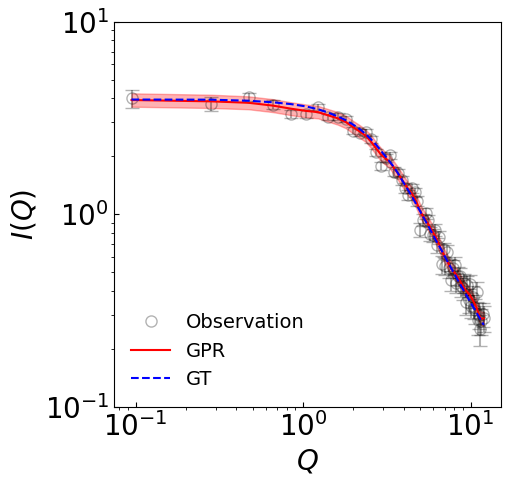

In [43]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.1

I_bg = 0

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_polymer) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_polymer, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(0, 4, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg
    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label='GPR')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label='GT')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-1, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=14)

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

### Sponge

1.1513953993264467


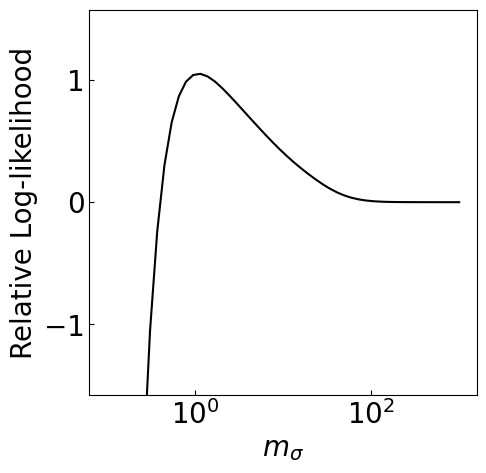

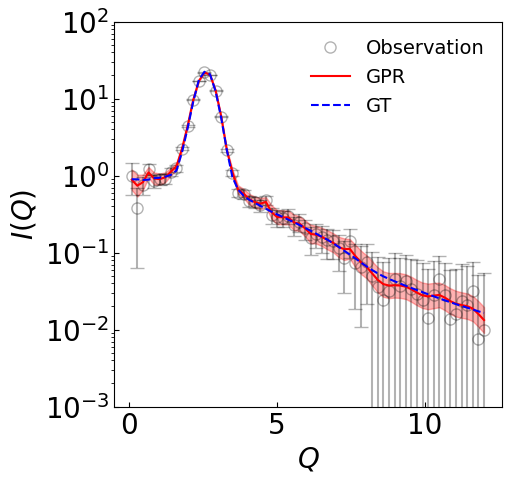

In [44]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.15

I_bg = 0

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_sponge) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_sponge, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg
    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg 

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
        ## average over the ovservation uncertainty   
        log_likelihood = 0   
        sum_weight = 0  
        for z in np.linspace(0, 0, 1):
            weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
            y_z = y + y_err*z
            log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
            log_likelihood += log_likelihood_z*weight_z
            sum_weight += weight_z
        log_likelihood = log_likelihood/sum_weight
        return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label='Observation', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label='GPR')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label='GT')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=14)

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label='GPR')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# # ax.set_yscale('log')

In [12]:
log_likelihood_list

array([-3.33388736e+03, -2.58153556e+03, -1.96577166e+03, -1.47314819e+03,
       -1.08588019e+03, -7.84696967e+02, -5.51402759e+02, -3.70659338e+02,
       -2.30691905e+02, -1.22970347e+02, -4.12945679e+01,  1.91592963e+01,
        6.24698427e+01,  9.22263172e+01,  1.11550035e+02,  1.23046386e+02,
        1.28788296e+02,  1.30362633e+02,  1.28971965e+02,  1.25573695e+02,
        1.21036980e+02,  1.16276463e+02,  1.12272519e+02,  1.09873723e+02,
        1.09402093e+02,  1.10317132e+02,  1.11284342e+02,  1.10736936e+02,
        1.07628469e+02,  1.01934185e+02,  9.46297224e+01,  8.71689488e+01,
        8.07593393e+01,  7.58519369e+01,  7.20896809e+01,  6.86263254e+01,
        6.45530109e+01,  5.92378090e+01,  5.25120201e+01,  4.46879877e+01,
        3.64115177e+01,  2.84112904e+01,  2.12668363e+01,  1.52936156e+01,
        1.05550575e+01,  6.94448777e+00,  4.27485058e+00,  2.34369739e+00,
        9.68493497e-01,  0.00000000e+00])